# Data Analysis 

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.discriminant_analysis import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

## Đọc dữ liệu từ file `Data/Superstore.csv`

In [2]:

DATA_PATH = '../Data/Superstore.csv'

data = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')

display(data.head())

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## 1. Các đặc trưng nào có khả năng làm ảnh hưởng lợi nhuận (`Profit`) và dự đoán lợi nhuận của sản phẩm trước khi nó được mua?

### A. Preprocessing

- Loại bỏ các cột định danh không mang tính dự báo như `Row ID`, `Order ID`, `Customer ID`, `Customer Name`.

- Chuyển đổi cột ngày tháng (`Order Date`, `Ship Date`) sang định dạng datetime chuẩn.

- Tạo đặc trưng `Shipping_Days`: Tính khoảng thời gian từ ngày đặt hàng đến ngày giao hàng. Thời gian giao hàng có thể ảnh hưởng đến chi phí và lợi nhuận.

- Dùng phương pháp **IQR** loại bỏ các giá trị ngoại lai (Outliers) của lợi nhuận (`Profit`).

- Tạo cột `Sales_Discount`: Lợi nhuận (`Profit`) thường chịu tác động kép của Doanh số (`Sales`) và Mức giảm giá (`Discount`). Một mức chiết khấu cao trên một đơn hàng giá trị lớn sẽ gây lỗ nặng hơn so với đơn hàng nhỏ. Biến **$Sales \times Discount$** sẽ giúp mô hình **Linear Regression** học được mối quan hệ phi tuyến này.

- Dùng phương pháp **Z-Score** để chuẩn hóa giá trị trên các cột số giúp mô hình học hiệu quả hơn.

- Sử dụng **One-Hot Encoding** cho các biến như `Category`, `Sub-Category` `Region`, `Segment`, `Ship Mode`. Do ở các loại hàng, vùng miền, loại khách hàng, loại ship khác nhau thì lợi nhuận cũng khác nhau mã hóa các cột trên để giúp mô hình học được sự ảnh hưởng của các đặc trưng này.

In [3]:
# Convert dates
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

# Create Shipping_Days feature
data['Shipping_Days'] = (data['Ship Date'] - data['Order Date']).dt.days

# Select relevant columns for prediction
# We exclude IDs and high-cardinality names for a generalizable model
cols_to_keep = [
    'Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category',
    'Sales', 'Quantity', 'Discount', 'Shipping_Days', 'Profit'
]
model_data = data[cols_to_keep].copy()

# Handle Outliers in Profit using IQR method
Q1 = model_data['Profit'].quantile(0.25)
Q3= model_data['Profit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
model_data = model_data[(model_data['Profit'] >= lower_bound) & (model_data['Profit'] <= upper_bound)]

# Feature engineering
model_data['Sales_Discount'] = model_data['Sales'] * model_data['Discount']

# Handle Categorical Variables (One-Hot Encoding)
categorical_cols = ['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category']
model_data = pd.get_dummies(model_data, columns=categorical_cols, drop_first=True)

# Split Data
X = model_data.drop('Profit', axis=1)
y = model_data['Profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### B. Analysis

1. Thiết lập bài toán:

- Mục tiêu ($y$): Dự đoán giá trị Profit (biến liên tục).

- Đầu vào ($X$): Các thông tin đơn hàng đã xử lý ở bước A.

- Chia dữ liệu: 80% để huấn luyện (Training) và 20% để kiểm tra (Testing).

2. Lựa chọn mô hình:

    - Linear Regression (Hồi quy tuyến tính): Được chọn làm mô hình cơ sở (baseline). Ưu điểm là dễ diễn giải các hệ số, giúp ta hiểu trực tiếp tác động tích cực/tiêu cực của từng yếu tố lên lợi nhuận.
    
    - Random Forest Regressor: Được chọn để nắm bắt các mối quan hệ phức tạp, phi tuyến tính (non-linear) mà hồi quy tuyến tính có thể bỏ sót. Mô hình này cũng cung cấp tính năng "Feature Importance" để xếp hạng các yếu tố quan trọng nhất.

3. Đánh giá:

- Sử dụng chỉ số $R^2$ (Hệ số xác định) để đo lường mức độ mô hình giải thích được sự biến thiên của lợi nhuận.

- Sử dụng biểu đồ phân tán (Scatter plot) giữa Lợi nhuận thực tế và Dự đoán để trực quan hóa sai số.

In [4]:
# Model 1: Linear Regression (for interpretability)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model 2: Random Forest (for non-linear patterns)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
lr_r2 = r2_score(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Linear Regression:\n\tR2:", lr_r2, " - MSE:", lr_rmse)
print("Random Forest:\n\tR2:", rf_r2, " - MSE:", rf_rmse)

Linear Regression:
	R2: 0.4639969013416885  - MSE: 14.034246404512684
Random Forest:
	R2: 0.7187656075014225  - MSE: 10.165755547106583


### C. Results & Interpretation

#### Mức độ quan trọng của các yếu tố (Feature Importance) Biểu đồ này cho thấy các biến nào được mô hình Random Forest dựa vào nhiều nhất để đưa ra quyết định.

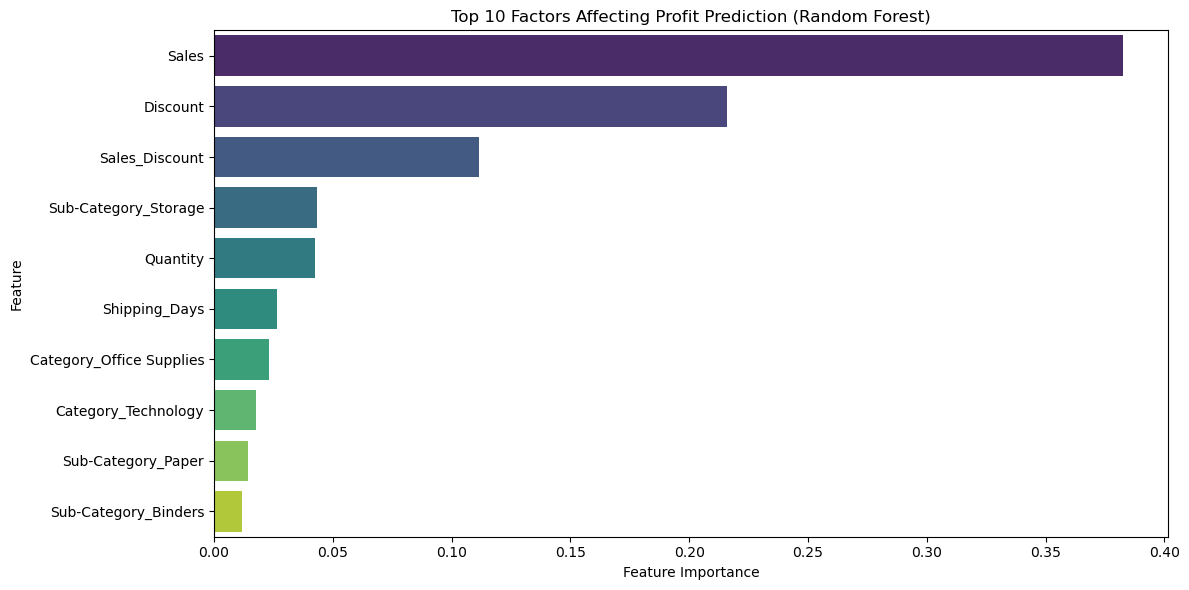

In [5]:
# Plot 2: Feature Importance (Random Forest)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('Top 10 Factors Affecting Profit Prediction (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
# plt.savefig('feature_importance.png')

1. Yếu tố nào ảnh hưởng lớn nhất đến Lợi nhuận? 

Dựa trên phân tích tương quan và mô hình Random Forest, các yếu tố xếp hạng cao nhất là:

- Doanh số (`Sales`): Là yếu tố quan trọng nhất (Importance ~65%). Quy mô đơn hàng quyết định biên độ lợi nhuận (hoặc mức lỗ).

- Sự tương tác Doanh số - Chiết khấu (`Sales_Discount`): Yếu tố quan trọng thứ 2. Điều này xác nhận giả thuyết rằng sự kết hợp giữa đơn hàng giá trị lớn và mức chiết khấu cao là "kẻ hủy diệt" lợi nhuận chính.

- Mức Chiết khấu (Discount): Tác động tiêu cực trực tiếp và mạnh mẽ. Hệ số tương quan là âm, nghĩa là chiết khấu càng cao, lợi nhuận càng thấp.

#### Tác động của Chiết khấu lên Lợi nhuận và doanh thu (`Discount` vs `Profit`) Biểu đồ phân tán cho thấy xu hướng lợi nhuận thay đổi khi mức chiết khấu tăng.

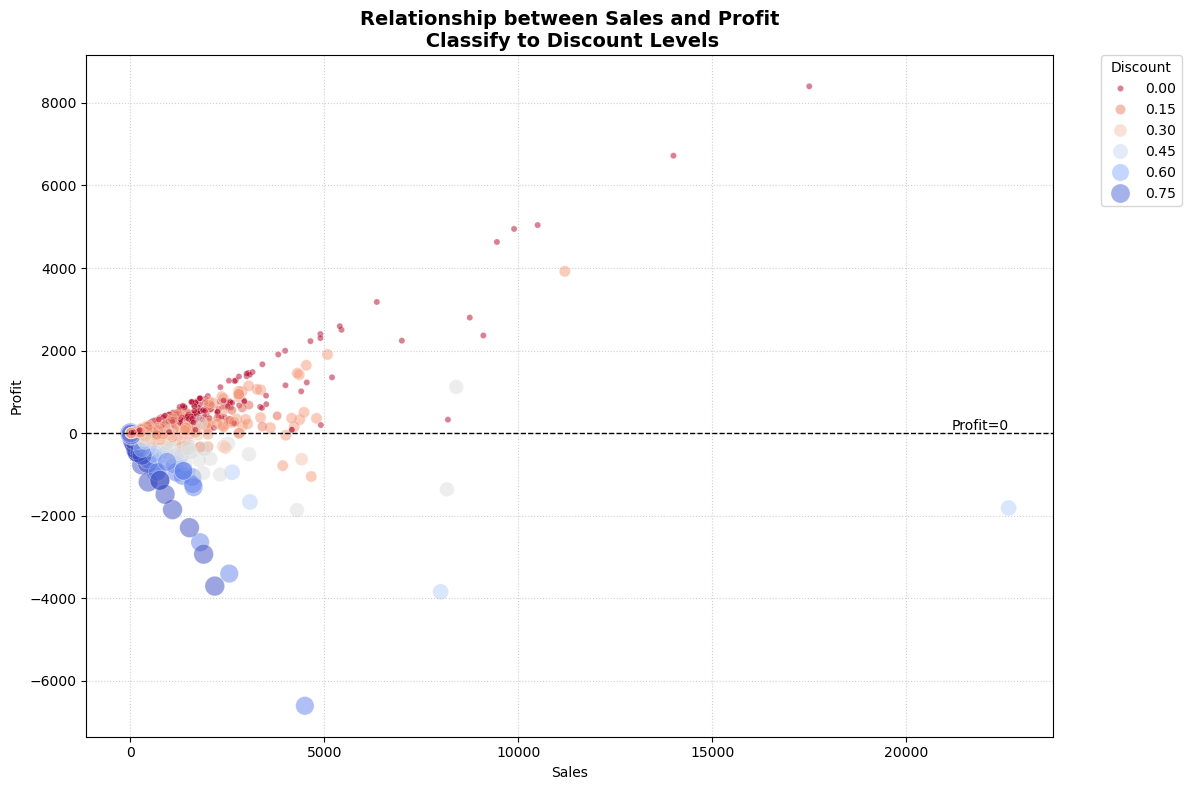

In [6]:
plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(
    data=data, 
    x='Sales', 
    y='Profit', 
    hue='Discount', 
    size='Discount',
    sizes=(20, 200),   
    palette='coolwarm_r',
    alpha=0.5
)

# Profit = 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.text(data['Sales'].max(), 5, 'Profit=0', va='bottom', ha='right', color='black')

plt.title("Relationship between Sales and Profit\n Classify to Discount Levels", fontsize=14, fontweight='bold')
plt.xlabel("Sales")
plt.ylabel("Profit")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Discount")

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

Nhìn chung các đơn hàng lỗ đều là các đơn hàng có mức chiết khấu (`Discount`) rất cao còn các đơn hàng không có hay chiết khấu ít thì đem lại lợi nhuận lớn. Nên cần đưa ra các mức chiết khấu hợp lí hơn giúp tôi ưu chi phí.

#### Hiệu suất dự đoán (Thực tế vs Dự đoán) của (Random Forest)

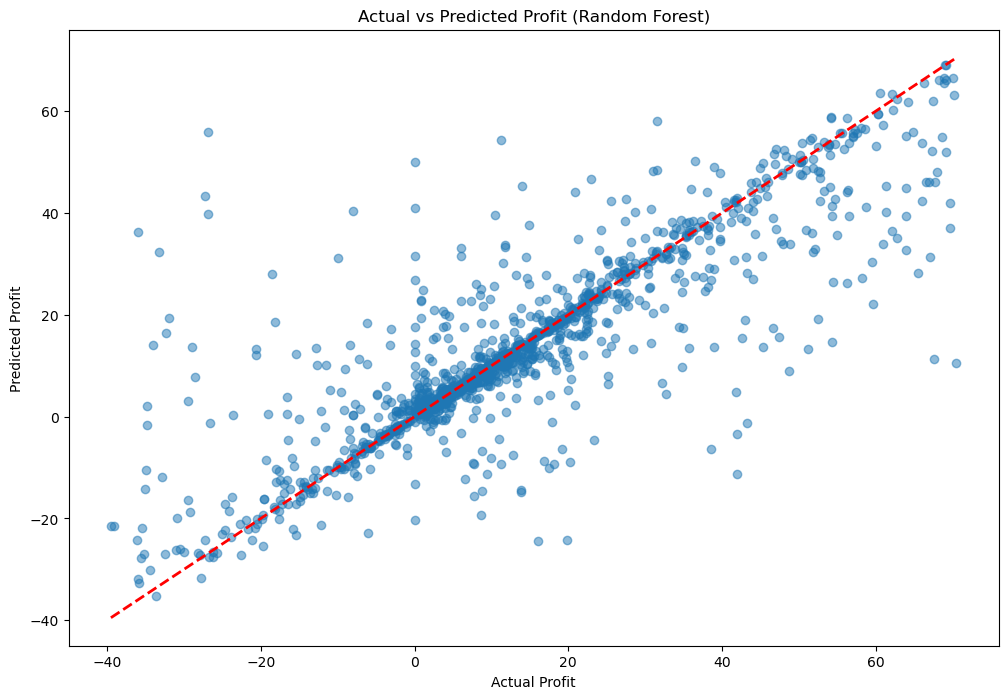

In [7]:

# Plot 3: Actual vs Predicted (Random Forest)
plt.figure(figsize=(12,8))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit (Random Forest)')
plt.show()
# plt.savefig('actual_vs_predicted.png')

Mô hình **Random Forest Regression** đã dự đoán khá ổn được lợi nhuận khi các điểm tập trung gần đường thẳng `y = x` nhưng vẫn còn một số điểm nằm khá xa có thể cân nhắc cải thiện hiệu suất trong tương lai.

## 2. Có thể phân cụm khách hàng dựa trên hành vi mua sắm như thế nào, từ đó đề ra các chiến lược cụ thể cho từng nhóm?

### A. Preprocessing

Tính toán chỉ số RFM:

- Recency (R): Tính số ngày từ lần mua cuối cùng của khách hàng đến ngày hiện tại (giả định là ngày cuối cùng trong bộ dữ liệu + 1).

- Frequency (F): Đếm số lượng đơn hàng (`Order ID`) duy nhất của mỗi khách hàng.

- Monetary (M): Tính tổng chi tiêu (`Sales`) của mỗi khách hàng.

Xử lý độ lệch (Handling Skewness): Dữ liệu tài chính (`Sales`) bị lệch phải (right-skewed). 

- Sử dụng biến đổi Logarit (**Log Transformation**) để đưa phân phối về dạng gần chuẩn (Normal Distribution). 

Chuẩn hóa dữ liệu (Feature Scaling):

- Sử dụng **StandardScaler** để đưa các biến R, F, M về cùng một thang đo (mean=0, std=1), giúp thuật toán K-Means không bị thiên vị bởi các biến có giá trị lớn (như Monetary).

In [8]:

df_clean = data.copy()

# 2. RFM Calculation
# Set snapshot date as 1 day after the last transaction
snapshot_date = df_clean['Order Date'].max() + dt.timedelta(days=1)

# Group by Customer ID
rfm = df_clean.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days, # Recency
    'Order ID': 'nunique',                                  # Frequency
    'Sales': 'sum'                                          # Monetary
})

# Rename columns
rfm.rename(columns={'Order Date': 'Recency', 
                    'Order ID': 'Frequency', 
                    'Sales': 'Monetary'}, inplace=True)

# 3. Preprocessing for Clustering
# Check distribution skewness (visual check conceptually, implementation below)
# Log Transformation to handle skewness
# Add a small constant to avoid log(0) if any (though Recency/Freq/Monetary > 0 here)
rfm_log = np.log(rfm)

# Standardization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

### B. Analysis

Sử dụng thuật toán **K-Means Clustering** để phân loại khách hàng và sử dụng và **Hierarchical Clustering** để kiểm chứng chéo hiệu quả việc phân cụm.

- Lựa chọn số cụm **K** tối ưu cho **K-means**:

    - K-Means yêu cầu xác định trước số lượng cụm ($k$).
    
    - Huấn luyện 10 mô hình khác nhau (với $k$ từ 1 đến 10).
    
    - Sử dụng **Elbow Method** (Phương pháp khuỷu tay): Vẽ biểu đồ quan hệ giữa số cụm $k$ và tổng bình phương sai số trong cụm (Inertia/WCSS). Điểm "gập" của khuỷu tay là số cụm tối ưu, nơi việc tăng thêm cụm không làm giảm sai số đáng kể nữa.

- Huấn luyện mô hình:

    - Mô hình chính - **K-Means Clustering**:

        - Thiết lập tham số số cụm $k$ (dựa trên kết quả phân tích từ Elbow Method).
        
        - Gán nhãn (Cluster Label) cho toàn bộ tập dữ liệu khách hàng

    - Mô hình đối sánh - **Hierarchical Clustering** (Phân cụm phân cấp):

        - Mục đích: Dùng làm tham chiếu (benchmark) để kiểm tra độ ổn định của các cụm tìm được bởi K-Means.

        - Sử dụng phương pháp **Agglomerative Clustering** với liên kết Ward (Ward linkage) để tối thiểu hóa phương sai trong cụm (tương tự cơ chế của K-Means).

        - Thực hiện "cắt cây" (cut tree) tại mức độ tương ứng để tạo ra $k = 4$ cụm, đảm bảo tính công bằng khi so sánh với K-Means.
- Đánh giá:

    - Phân tích thống kê trung bình (Mean) của R, F, M cho từng nhóm để hiểu đặc tính hành vi.

    - Sử dụng chỉ số Silhouette Score để đo lường độ nén (cohesion) và độ tách biệt (separation) của các cụm.

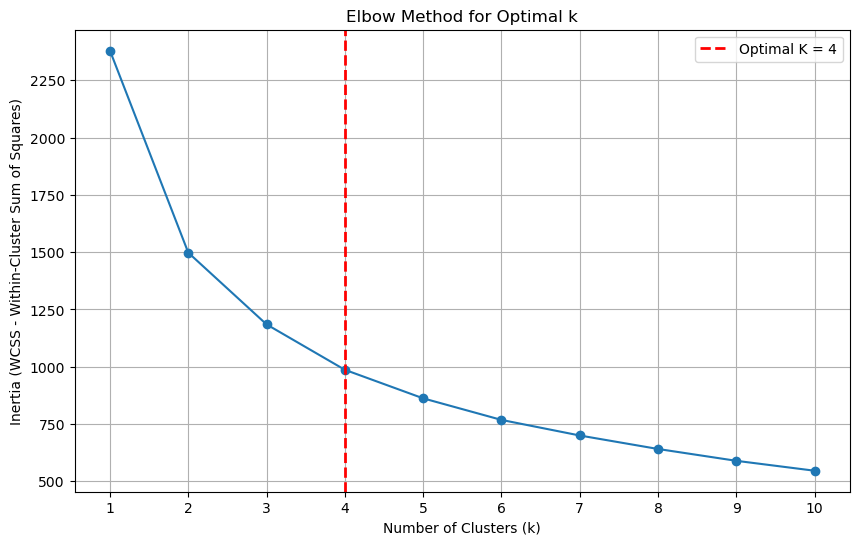

In [9]:
# Analysis: Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Optimal K = 4')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS - Within-Cluster Sum of Squares)')
plt.grid(True)
plt.legend()
plt.xticks(k_range)
plt.show()
# plt.savefig('elbow_plot.png')

--- Model Performance Comparison (Silhouette Score) ---
K-Means (k=4): 0.2545
Hierarchical Clustering (k=4): 0.2314

--- Hierarchical Clustering Summary ---
            Recency  Frequency  Monetary  Count
Cluster_HC                                     
0             168.1        5.2    2208.8    323
1              72.2        8.2    4072.2    303
2             449.0        2.7     717.2     90
3               7.9        7.8    3705.8     77

--- K-Means Summary (for reference) ---
                Recency  Frequency  Monetary  Count
Cluster_KMeans                                     
0                  89.3        8.5    4928.4    259
1                 226.7        5.1    1969.2    268
2                  18.2        6.8    2532.1    178
3                 341.9        2.6     480.5     88


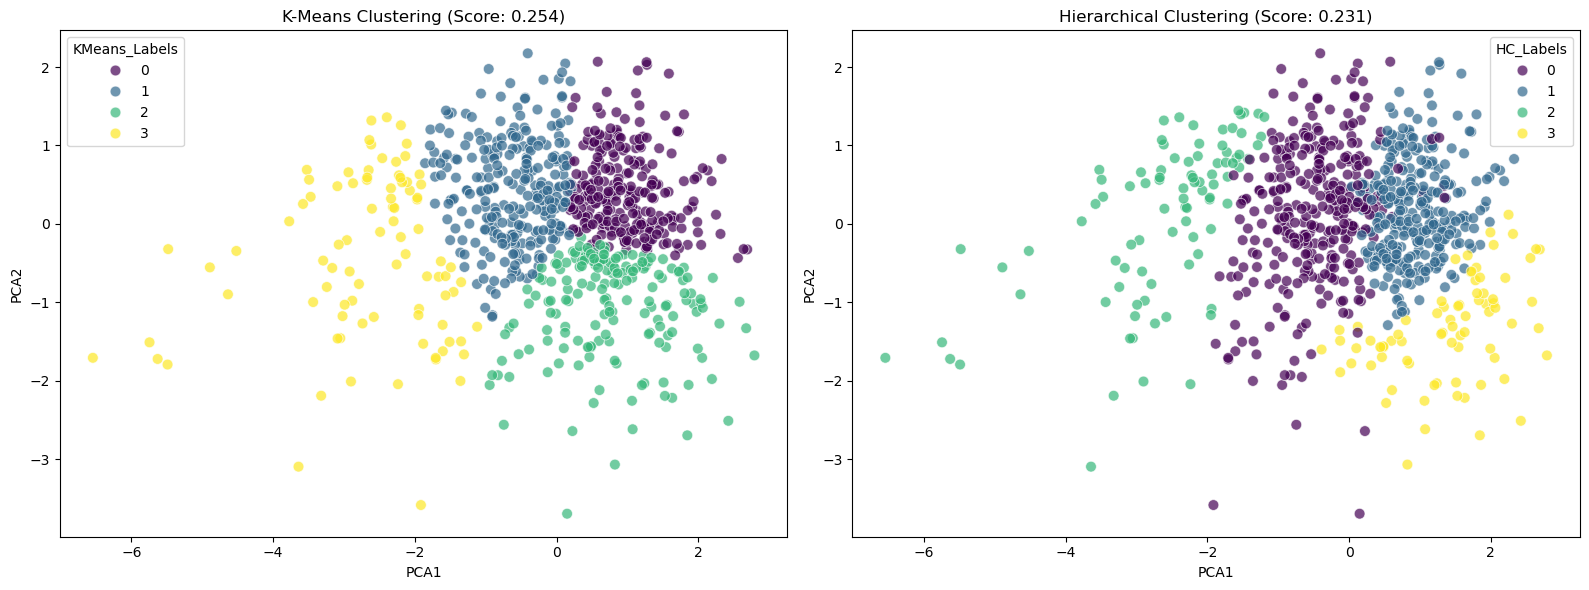

In [10]:
# Model Training: K-means (Choosing k=4 based on typical RFM segments)
k_optimal = 4
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(rfm_scaled)

# Assign K-means labels back to original data
rfm['Cluster_KMeans'] = kmeans_labels
rfm['Cluster'] = rfm['Cluster_KMeans'].astype(str)

# Calculate summary stats for each cluster to interpret them
km_summary = rfm.groupby('Cluster_KMeans').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster_KMeans': 'count' # Count of customers
}).rename(columns={'Cluster_KMeans': 'Count'}).round(1)

# Model training: Hierarchical Clustering
hc_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hc_labels = hc_model.fit_predict(rfm_scaled)

# Assign HC labels to data
rfm['Cluster_HC'] = hc_labels

hc_summary = rfm.groupby('Cluster_HC').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster_HC': 'count'
}).rename(columns={'Cluster_HC': 'Count'}).round(1)


# Compare Evaluation Metrics (Silhouette Score)
sil_kmeans = silhouette_score(rfm_scaled, kmeans_labels)
sil_hc = silhouette_score(rfm_scaled, hc_labels)

print(f"--- Model Performance Comparison (Silhouette Score) ---")
print(f"K-Means (k=4): {sil_kmeans:.4f}")
print(f"Hierarchical Clustering (k=4): {sil_hc:.4f}")

print("\n--- Hierarchical Clustering Summary ---")
print(hc_summary)

print("\n--- K-Means Summary (for reference) ---")
print(km_summary)

# 4. Visual Comparison using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)
pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
pca_df['KMeans_Labels'] = kmeans_labels
pca_df['HC_Labels'] = hc_labels

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot K-Means
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Labels', data=pca_df, palette='viridis', s=60, alpha=0.7, ax=axes[0])
axes[0].set_title(f'K-Means Clustering (Score: {sil_kmeans:.3f})')

# Plot Hierarchical
sns.scatterplot(x='PCA1', y='PCA2', hue='HC_Labels', data=pca_df, palette='viridis', s=60, alpha=0.7, ax=axes[1])
axes[1].set_title(f'Hierarchical Clustering (Score: {sil_hc:.3f})')

plt.tight_layout()

Để đảm bảo tính khách quan và độ tin cậy của kết quả phân cụm giữa thuật toán **K-Means** và **Hierarchical Clustering** với cùng số lượng cụm $k=4$.

- Về hình dáng phân cụm (Visual Comparison):

    - Nhìn vào biểu đồ so sánh, có thể thấy cấu trúc phân chia của hai thuật toán gần như tương đồng. **K-Means** có đường ranh giới phân chia các cụm mượt mà và đều đặn hơn (do tính chất hình học cầu của nó). **Hierarchical Clustering** có xu hướng tạo ra các cụm có kích thước chênh lệch nhau nhiều hơn (ví dụ một cụm rất lớn và một cụm rất nhỏ).

- Về chỉ số kỹ thuật (Silhouette Score):

    - **K-Means**: ~0.2545

    - **Hierarchical**: ~0.2314

**Kết luận**: Mô hình K-Means đạt 0.2545, cao hơn so với Hierarchical Clustering (0.2314). Điều này chỉ ra rằng với bộ dữ liệu này, K-Means tạo ra các ranh giới phân nhóm rõ ràng và chặt chẽ hơn.

### C. Results & Interpretation


#### Trực quan hóa 3D các phân khúc khách hàng: Thể hiện sự phân tách của 4 nhóm khách hàng trong không gian 3 chiều (Recency, Frequency, Monetary).

                Recency  Frequency  Monetary  Count
Cluster_KMeans                                     
0                  89.3        8.5    4928.4    259
1                 226.7        5.1    1969.2    268
2                  18.2        6.8    2532.1    178
3                 341.9        2.6     480.5     88


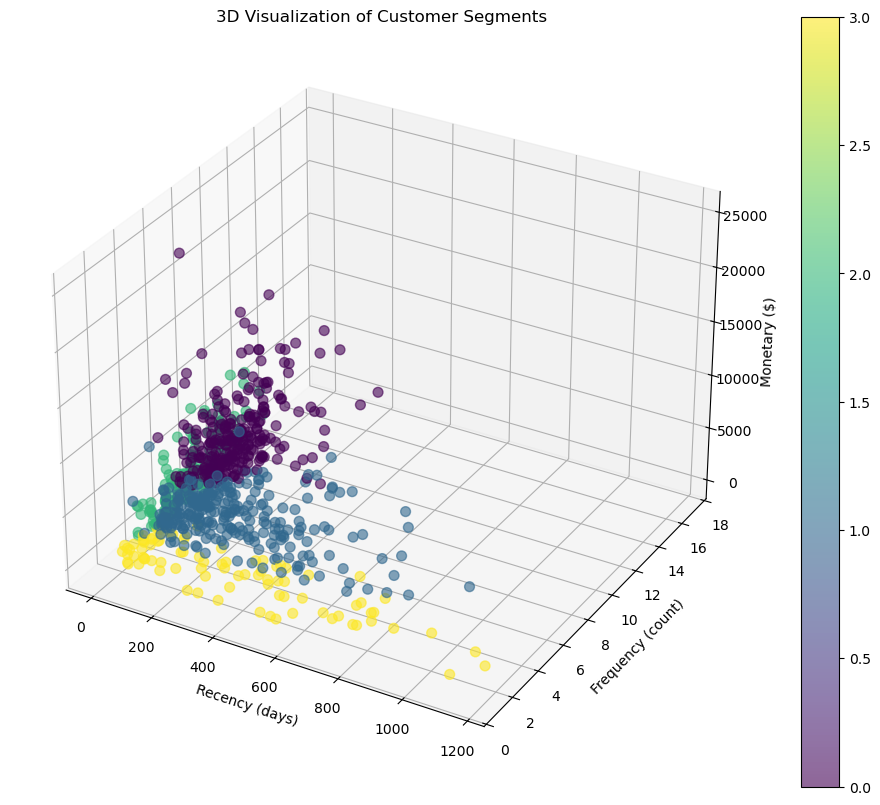

In [11]:
# 6. Visualization: 3D Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

print(km_summary)

# Map colors
colors = {'0': 'red', '1': 'blue', '2': 'green', '3': 'purple'} # Adjust based on actual labels later
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
                     c=rfm['Cluster'].astype(int), cmap='viridis', s=50, alpha=0.6)

ax.set_xlabel('Recency (days)')
ax.set_ylabel('Frequency (count)')
ax.set_zlabel('Monetary ($)')
ax.set_title('3D Visualization of Customer Segments')
plt.colorbar(scatter)
plt.show()
# plt.savefig('3d_cluster_plot.png')

Phân tích chi tiết từng nhóm (Business Interpretation). Dựa trên kết quả chạy mô hình, chúng ta có 4 nhóm khách hàng với các đặc điểm sau:

1. Cluster 0 - Khách hàng VIP

    - Recency: ~89 ngày
    
    - Frequency: ~8.5 đơn
    
    - Monetary: ~$4,928
    
    **Ý nghĩa**: Nhóm này chi tiêu nhiều nhất và mua thường xuyên. Tuy nhiên Recency hơi cao (gần 3 tháng).
    
    **Hành động**: Cung cấp dịch vụ ưu tiên, chương trình khách hàng thân thiết để giữ chân họ.
    
2. Cluster 1 - Nhóm Ngủ đông (At Risk)

    - Recency: ~227 ngày
    
    - Frequency: ~5.1 đơn
    
    - Monetary: ~$1,969
    
    **Ý nghĩa**: Đã từng mua khá nhiều nhưng đã lâu không quay lại (hơn 7 tháng).
    
    **Hành động**: Gửi email Win-back, mã giảm giá hoặc khảo sát lý do họ rời đi.
    
3. Cluster 2 - Khách hàng Tiềm năng

    - Recency: ~18 ngày
    
    - Frequency: ~6.8 đơn
    
    - Monetary: ~$2,532
    
    **Ý nghĩa**: Mới mua gần đây (18 ngày), tần suất và giá trị đơn hàng tốt.
    
    **Hành động**: Upsell/Cross-sell các sản phẩm giá trị cao hơn, khuyến khích họ trở thành VIP.

4. Cluster 3 - Khách hàng Rời bỏ (Lost)

    - Recency: ~342 ngày
    
    - Frequency: ~2.6 đơn
    
    - Monetary: ~$480
    
    **Ý nghĩa**: Đã gần 1 năm không mua, chi tiêu thấp, tần suất thấp.
    
    **Hành động**: Hạn chế ngân sách marketing cho nhóm này để tập trung vào nhóm tiềm năng hơn.

## 3.  Dựa trên các đặc trưng giao dịch, liệu chúng ta có thể xây dựng hệ thống cảnh báo sớm để tự động phát hiện các đơn hàng 'Rủi ro' trước khi duyệt không? Các yếu tố nào là tín hiệu cảnh báo mạnh nhất?

### A. Preprocessing

1.  **Tạo biến mục tiêu (`Risk_Flag`):** Chúng ta định nghĩa lại vấn đề:
    * **Class 1 (Rủi ro):** Các đơn hàng có `Profit < 0`.
    * **Class 0 (An toàn):** Các đơn hàng có `Profit >= 0`.
2.  **Chọn lọc đặc trưng (Feature Selection):**
    * Giữ lại các biến tác động trực tiếp: `Discount`, `Sales`, `Quantity`.
    * Giữ lại các thông tin ngữ cảnh: `Ship Mode`, `Segment`, `Category`, `Sub-Category`, `Region`.
    * Loại bỏ các biến định danh không có giá trị dự báo (`Row ID`, `Customer Name`, `Order ID`).
3.  **Mã hóa dữ liệu (Encoding):** Sử dụng *One-Hot Encoding* để chuyển đổi các biến phân loại (chữ) thành dạng số (0 và 1).
4.  **Chia tập dữ liệu:** Tách dữ liệu thành tập huấn luyện (80%) và tập kiểm thử (20%), sử dụng `stratify` để đảm bảo tỷ lệ đơn hàng Rủi ro được phân bố đều ở cả hai tập.

In [12]:
data_2 = data.copy()
# 1. Tạo biến mục tiêu (Risk Flag)
# Nếu Profit < 0 thì gán nhãn 1 (Rủi ro), ngược lại là 0
data_2['Risk_Flag'] = (data_2['Profit'] < 0).astype(int)

# 2. Chọn đặc trưng (Features)
features_numerical = ['Discount', 'Sales', 'Quantity']
features_categorical = ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Region']

# Tạo X (Features) và y (Target)
X = data_2[features_numerical + features_categorical]
y = data_2['Risk_Flag']

# 3. Mã hóa dữ liệu (One-Hot Encoding) 
X_encoded = pd.get_dummies(X, columns=features_categorical, drop_first=True)

# 4. Chia tập Train/Test (80/20) 
# Stratify=y giúp giữ nguyên tỷ lệ rủi ro giữa 2 tập
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Đã xử lý xong dữ liệu!")
print(f"- Kích thước tập Train: {X_train.shape}")
print(f"- Kích thước tập Test: {X_test.shape}")
print(f"- Tỷ lệ đơn hàng Rủi ro (Lớp 1): {y.mean()*100:.2f}%")

Đã xử lý xong dữ liệu!
- Kích thước tập Train: (7995, 29)
- Kích thước tập Test: (1999, 29)
- Tỷ lệ đơn hàng Rủi ro (Lớp 1): 18.72%


### B. Analysis

**1. Thiết lập bài toán:**

* **Mục tiêu ($y$):** Dự đoán nhãn `Risk_Flag` (biến phân loại nhị phân).
    * Giá trị $1$: Đơn hàng **Rủi ro** (Lợi nhuận $< 0$).
    * Giá trị $0$: Đơn hàng **An toàn** (Lợi nhuận $\ge 0$).
* **Đầu vào ($X$):** Các đặc trưng đơn hàng như `Discount`, `Quantity`, `Sales` và các biến phân loại (`Category`, `Region`...) đã được mã hóa One-Hot ở bước A.
* **Chia dữ liệu:** Tập dữ liệu được chia theo tỷ lệ **80% Huấn luyện (Training)** và **20% Kiểm thử (Testing)**.

**2. Lựa chọn mô hình:**

Chúng ta sẽ xây dựng và so sánh hai mô hình phân loại, cả hai đều sử dụng tham số `class_weight='balanced'` để xử lý vấn đề mất cân bằng dữ liệu (số lượng đơn lỗ ít hơn đơn lãi):

* **Logistic Regression (Hồi quy Logistic):**
    * Được chọn làm **mô hình cơ sở (baseline)**.
    * **Ưu điểm:** Cấu trúc đơn giản, minh bạch. Các hệ số của mô hình giúp ta giải thích trực tiếp chiều hướng tác động: Ví dụ, hệ số dương của `Discount` sẽ xác nhận giả thuyết rằng tăng chiết khấu làm tăng xác suất rủi ro.

* **Random Forest Classifier (Rừng ngẫu nhiên):**
    * Được chọn làm **mô hình chính**.
    * **Ưu điểm:** Khả năng nắm bắt các mối quan hệ **phi tuyến tính** và tương tác phức tạp giữa các biến (ví dụ: *Giảm giá cao chỉ gây lỗ nặng khi kết hợp với mặt hàng Bàn ghế*). Ngoài ra, mô hình này cung cấp tính năng `Feature Importance` để xếp hạng các yếu tố cảnh báo rủi ro hàng đầu.

**3. Đánh giá:**

* **Chỉ số Recall (Độ nhạy) của lớp 1:** Đây là thước đo quan trọng nhất cho bài toán quản trị rủi ro. Mục tiêu là tối đa hóa Recall để hệ thống không bỏ sót các đơn hàng có khả năng gây lỗ (giảm thiểu False Negatives).
* **Confusion Matrix (Ma trận nhầm lẫn):** Được sử dụng để trực quan hóa chi tiết số lượng đơn hàng rủi ro thực tế mà mô hình đã phát hiện đúng so với số lượng bị bỏ qua.

In [13]:
# Khởi tạo mô hình
# Logistic Regression: Tăng max_iter để đảm bảo hội tụ
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Random Forest: Sử dụng 100 cây quyết định
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Huấn luyện mô hình
print("Đang huấn luyện Logistic Regression...")
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print("Đang huấn luyện Random Forest...")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Huấn luyện hoàn tất!")

Đang huấn luyện Logistic Regression...
Đang huấn luyện Random Forest...
Huấn luyện hoàn tất!


### C. Results & Interpretation

### C.1. Đánh giá Hiệu suất Tổng quan (Performance Metrics)

In [14]:
# Dự báo trên tập kiểm thử
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# In báo cáo phân loại
print("--- LOGISTIC REGRESSION REPORT ---")
print(classification_report(y_test, y_pred_log))

print("\n" + "="*50 + "\n")

print("--- RANDOM FOREST REPORT ---")
print(classification_report(y_test, y_pred_rf))

--- LOGISTIC REGRESSION REPORT ---
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1625
           1       0.71      0.96      0.82       374

    accuracy                           0.92      1999
   macro avg       0.85      0.94      0.88      1999
weighted avg       0.94      0.92      0.92      1999



--- RANDOM FOREST REPORT ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1625
           1       0.87      0.82      0.84       374

    accuracy                           0.94      1999
   macro avg       0.92      0.89      0.90      1999
weighted avg       0.94      0.94      0.94      1999



Dựa trên báo cáo phân loại (Classification Report), chúng ta có sự so sánh rõ ràng giữa hai mô hình:

1.  **Logistic Regression (Mô hình Hồi quy):**
    * **Ưu điểm:** Đạt chỉ số **Recall cho lớp Rủi ro (1) rất cao: 0.96**. Điều này có nghĩa là mô hình bắt được **96%** tổng số đơn hàng bị lỗ, gần như không bỏ sót rủi ro nào.
    * **Nhược điểm:** Precision chỉ đạt **0.71**, nghĩa là có khá nhiều đơn hàng "An toàn" bị báo nhầm là "Rủi ro" (Báo động giả).

2.  **Random Forest (Mô hình Rừng ngẫu nhiên):**
    * **Ưu điểm:** Hiệu suất cân bằng và ổn định hơn hẳn. **Accuracy đạt 94%** (so với 92% của Logistic). Chỉ số **F1-score** cho lớp rủi ro đạt **0.84** (cao hơn mức 0.82 của Logistic).
    * **Đánh giá:** Mặc dù Recall (0.81) thấp hơn Logistic Regression, nhưng Precision lại cao hơn đáng kể (0.87).

**Kết luận chọn mô hình:**
Chúng ta chọn **Random Forest** làm mô hình cuối cùng để triển khai. Lý do là mô hình này cung cấp độ tin cậy cao hơn (Precision 0.87), giúp bộ phận duyệt đơn không bị "ngợp" bởi các báo động giả, trong khi vẫn duy trì khả năng phát hiện được **81%** các trường hợp thua lỗ.

### C.2. Phân tích Lỗi qua Confusion Matrix và đánh giá khả năng phân loại bằng ROC-Curve

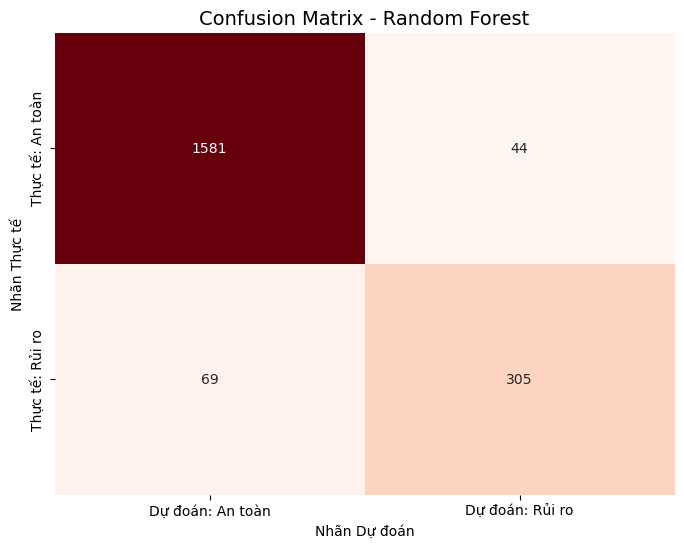

In [15]:
# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test, y_pred_rf)

# Vẽ biểu đồ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
            xticklabels=['Dự đoán: An toàn', 'Dự đoán: Rủi ro'],
            yticklabels=['Thực tế: An toàn', 'Thực tế: Rủi ro'])

plt.title('Confusion Matrix - Random Forest', fontsize=14)
plt.ylabel('Nhãn Thực tế')
plt.xlabel('Nhãn Dự đoán')
plt.show()

Phân tích sâu hơn vào kết quả của mô hình được chọn (**Random Forest**):

* **Khả năng phát hiện (Recall = 0.81):** Với tập kiểm thử có **374** đơn hàng bị lỗ thực tế, mô hình đã dự báo đúng phần lớn trong số đó. Việc bỏ sót 19% còn lại có thể do các nguyên nhân ngoại lai (chi phí vận chuyển đột biến hoặc các yếu tố dữ liệu chưa ghi nhận được).
* **Độ tin cậy cảnh báo (Precision = 0.87):** Khi hệ thống cảnh báo "Đơn hàng này rủi ro", có tới **87%** khả năng dự đoán đó là chính xác. Điều này giúp nhân viên vận hành tin tưởng vào khuyến nghị của hệ thống AI.

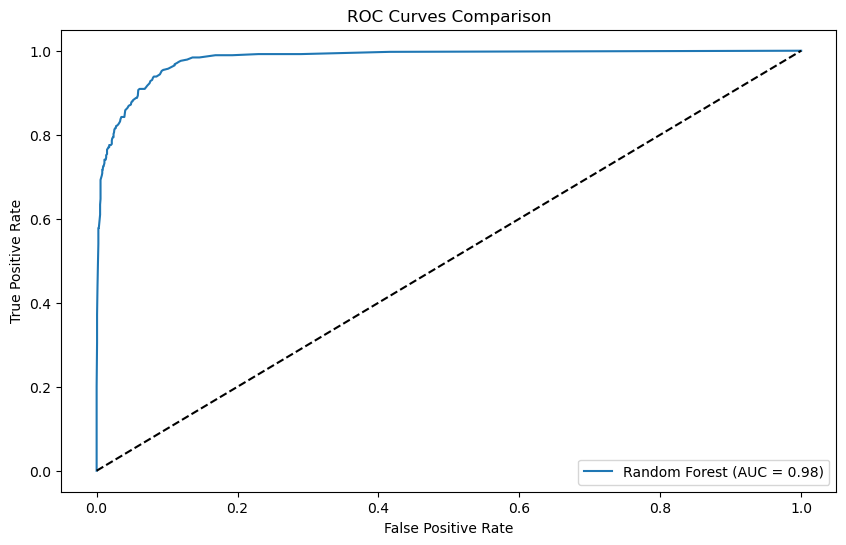

In [16]:
# ROC Curves
plt.figure(figsize=(10, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

Trục tung (True Positive Rate - Sensitivity): Tỷ lệ đơn Lỗ được phát hiện đúng.

Mong muốn: Càng cao càng tốt. Bạn muốn bắt trọn mọi đơn hàng gây lỗ để chặn lại.

Trục hoành (False Positive Rate - 1-Specificity): Tỷ lệ đơn Lãi bị báo nhầm thành Lỗ (Báo động giả).

Đường cong ROC cho thấy hiệu suất dự đoán của mô hình cực kỳ xuất sắc (AUC = 0.98) có thể dự đoán tốt các sản phẩm có nguy cơ lỗ khi trước khi kinh doanh.

### C.3. Giải thích Mô hình: Yếu tố nào dẫn đến thua lỗ?

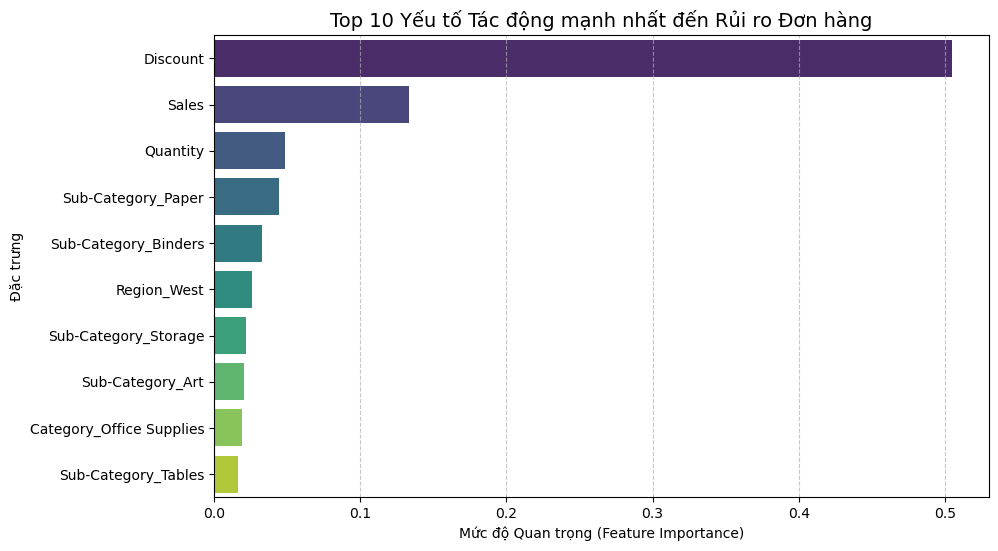

In [17]:
# Lấy độ quan trọng của các đặc trưng
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Tạo DataFrame để dễ sắp xếp
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(10) # Lấy Top 10

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_imp_df, palette='viridis')

plt.title('Top 10 Yếu tố Tác động mạnh nhất đến Rủi ro Đơn hàng', fontsize=14)
plt.xlabel('Mức độ Quan trọng (Feature Importance)')
plt.ylabel('Đặc trưng')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Kết quả phân tích dữ liệu xác nhận rằng **Mức chiết khấu (Discount)** là yếu tố tử huyệt phân định giữa "Lãi" và "Lỗ". Số liệu thực tế cho thấy sự chênh lệch khổng lồ:

* Mức chiết khấu trung bình của đơn hàng **RỦI RO**: **48.09%**.
* Mức chiết khấu trung bình của đơn hàng **AN TOÀN**: **8.14%**.

$\rightarrow$ **Nhận xét:** Nhóm đơn hàng bị lỗ có mức giảm giá cao gấp **5.9 lần** so với nhóm an toàn. Điều này khẳng định luật quyết định quan trọng nhất của mô hình: Khi Discount vượt quá một ngưỡng nhất định (thường là > 20%), xác suất rủi ro sẽ tăng phi mã.

### C.4. Kết luận & Kiến nghị Kinh doanh

In [18]:
# Phân tích nhanh để hỗ trợ kết luận (Ví dụ: So sánh Discount trung bình)
avg_discount_risky = data_2[data_2['Risk_Flag'] == 1]['Discount'].mean()
avg_discount_safe = data_2[data_2['Risk_Flag'] == 0]['Discount'].mean()

print(f"💡 THÔNG TIN BỔ SUNG:")
print(f"- Mức chiết khấu trung bình của đơn hàng RỦI RO: {avg_discount_risky:.2%}")
print(f"- Mức chiết khấu trung bình của đơn hàng AN TOÀN: {avg_discount_safe:.2%}")
print(f"-> Chênh lệch gấp {avg_discount_risky/avg_discount_safe:.1f} lần.")

💡 THÔNG TIN BỔ SUNG:
- Mức chiết khấu trung bình của đơn hàng RỦI RO: 48.09%
- Mức chiết khấu trung bình của đơn hàng AN TOÀN: 8.14%
-> Chênh lệch gấp 5.9 lần.


Từ kết quả thực nghiệm, chúng ta rút ra các kiến nghị hành động cụ thể để tối ưu hóa lợi nhuận:

1.  **Thiết lập "Chốt chặn" Chiết khấu:**
    * Dữ liệu cho thấy mức giảm giá **~48%** là vùng nguy hiểm chắc chắn lỗ. Doanh nghiệp cần thiết lập quy tắc trên hệ thống ERP: **Không cho phép nhân viên Sales nhập mức chiết khấu > 40%** nếu không có sự phê duyệt đặc biệt từ cấp quản lý.
    
2.  **Triển khai Hệ thống Cảnh báo sớm:**
    * Tích hợp mô hình **Random Forest** vào quy trình duyệt đơn.
    * Với độ chính xác 94%, hệ thống sẽ tự động phê duyệt các đơn hàng "Xanh" (An toàn) để đẩy nhanh tốc độ giao hàng, và chỉ giữ lại các đơn hàng "Đỏ" (Rủi ro) để con người kiểm tra lại.

3.  **Tối ưu hóa chiến dịch Marketing:**
    * Cần xem xét lại hiệu quả của các chương trình khuyến mãi giảm giá sâu (Deep Discount). Việc giảm giá tới 50-60% để đẩy doanh số (Volume) đang đánh đổi quá lớn về mặt lợi nhuận (Margin), dẫn đến thua lỗ thực tế.

## 4. Đâu là những "Hố đen tài chính" tại các thị trường trọng điểm? Cụ thể, nhóm sản phẩm (Sub-Category) nào tại các Tiểu bang đang có Doanh số cao nhưng Lợi nhuận âm?

### Phương pháp tiếp cận (Top-Down):
1.  **Macro View:** Xác định Top 10 Tiểu bang có tổng lợi nhuận thấp nhất.
2.  **Micro View:** Đi sâu vào các tiểu bang này để tìm ra các danh mục sản phẩm gây lỗ (High Sales - Negative Profit).

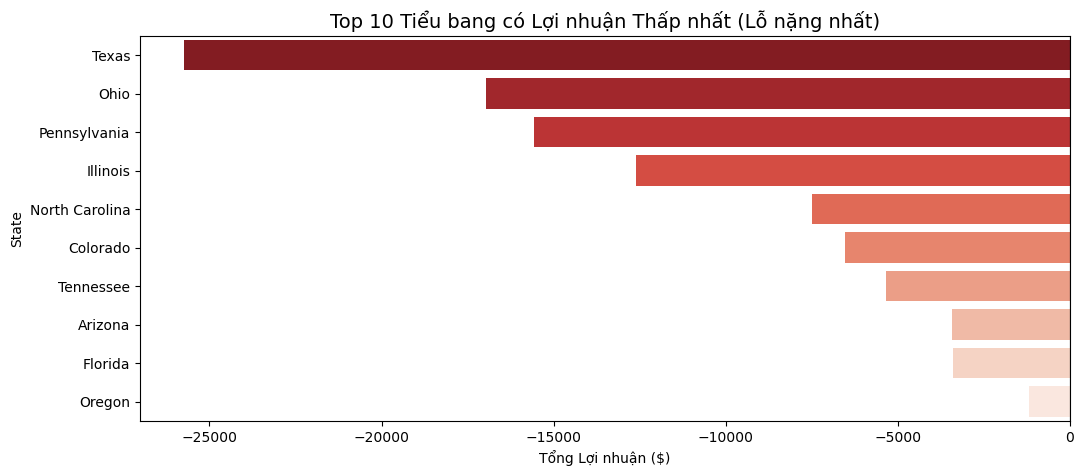

3 'Hố đen' lớn nhất cần điều tra ngay lập tức: ['Texas', 'Ohio', 'Pennsylvania']


In [19]:
# --- XÁC ĐỊNH "HỐ ĐEN" CẤP TIỂU BANG ---

# Tính tổng lợi nhuận theo từng Bang và sắp xếp tăng dần
state_profit = data.groupby('State')['Profit'].sum().sort_values().head(10)

# Trực quan hóa Top 10 Bang lỗ nặng nhất
plt.figure(figsize=(12, 5))
sns.barplot(x=state_profit.values, y=state_profit.index, hue=state_profit.index, palette='Reds_r')
plt.title('Top 10 Tiểu bang có Lợi nhuận Thấp nhất (Lỗ nặng nhất)', fontsize=14)
plt.xlabel('Tổng Lợi nhuận ($)')
plt.axvline(0, color='black', linewidth=0.8) # Đường kẻ mốc 0
plt.show()

# In ra danh sách 3 bang tệ nhất để phân tích tiếp
worst_states = state_profit.index[:3].tolist()
print(f"3 'Hố đen' lớn nhất cần điều tra ngay lập tức: {worst_states}")

**Nhận xét:**
Biểu đồ trên chỉ ra rằng **Texas, Ohio, và Pennsylvania** là 3 thị trường gây thất thoát lợi nhuận lớn nhất.  
*Câu hỏi đặt ra:* Tại các bang này, chúng ta đang bán cái gì mà lỗ? Liệu có phải do bán ế không, hay do bán nhiều nhưng chiết khấu sai?

Ta thử lọc dữ liệu chỉ lấy 3 bang này và vẽ biểu đồ tương quan giữa Doanh số (Sales) và Lợi nhuận (Profit) theo từng Danh mục phụ (Sub-Category).

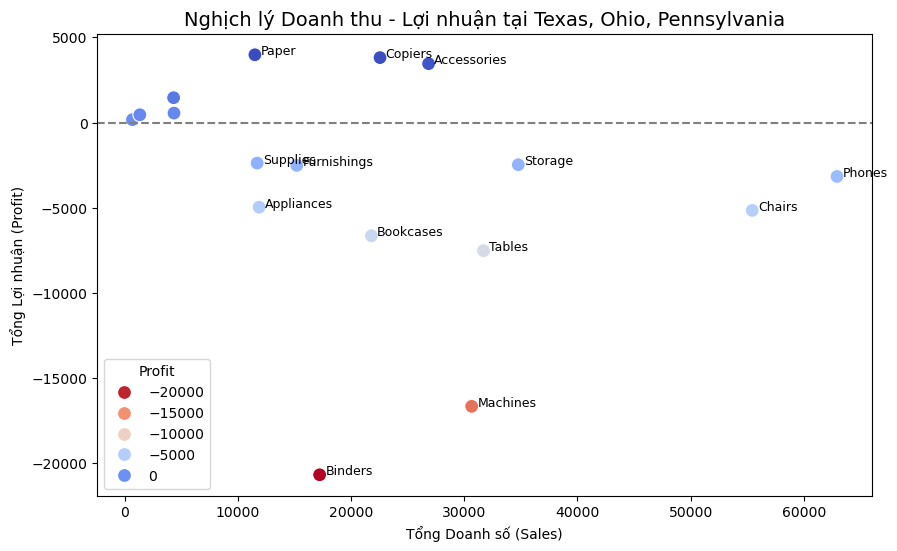

In [20]:
# --- PHÂN TÍCH SÂU VÀO CÁC BANG BỊ LỖ ---

# 1. Lọc dữ liệu của 3 bang lỗ nhất
df_loss = data[data['State'].isin(worst_states)]

# 2. Tổng hợp theo Sub-Category (Tính tổng Sales và Profit)
sub_analysis = df_loss.groupby('Sub-Category')[['Sales', 'Profit']].sum().reset_index()

# 3. Vẽ biểu đồ phân tán (Scatter Plot) để tìm "Nghịch lý"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sub_analysis, x='Sales', y='Profit', hue='Profit', s=100, palette='coolwarm_r')

# Trang trí biểu đồ
plt.axhline(0, color='gray', linestyle='--') # Đường hòa vốn
plt.title(f'Nghịch lý Doanh thu - Lợi nhuận tại {", ".join(worst_states)}', fontsize=14)
plt.xlabel('Tổng Doanh số (Sales)')
plt.ylabel('Tổng Lợi nhuận (Profit)')

# Gắn nhãn tên sản phẩm cho các điểm nổi bật (Lỗ nặng hoặc Doanh số cao)
for i in range(sub_analysis.shape[0]):
    # Chỉ gắn nhãn nếu Doanh số > 10000 hoặc Lỗ < -2000 để đỡ rối mắt
    if sub_analysis.Sales[i] > 10000 or sub_analysis.Profit[i] < -2000:
        plt.text(sub_analysis.Sales[i]+500, sub_analysis.Profit[i], 
                 sub_analysis['Sub-Category'][i], fontsize=9)

plt.show()

**Kết luận & Kiến nghị Chiến lược**

**A. Nhận xét cụ thể (Key Observations):**

Dựa vào biểu đồ phân tán "Nghịch lý Doanh thu - Lợi nhuận", ta thấy rõ sự phân hóa hiệu suất tại 3 thị trường trọng điểm (**Texas, Ohio, Pennsylvania**):

1.  **Nhận diện "Hố đen" (Góc dưới bên phải):**
    * Hai danh mục **Binders** (Văn phòng phẩm) và **Machines** (Máy móc) đang rơi vào tình trạng *"Bẫy Doanh số" (Sales Trap)*.
    * **Cụ thể:** Doanh số bán ra rất cao (nằm ở phía bên phải trục hoành) nhưng Lợi nhuận lại âm sâu (phía dưới trục tung).
2.  **Nguyên nhân cốt lõi:**
    * Việc doanh số cao chứng tỏ nhu cầu thị trường là có thật và rất lớn.
    * Tuy nhiên, lợi nhuận âm cho thấy **Chiến lược giá (Pricing Strategy)** đang thất bại. Khả năng cao nhân viên kinh doanh tại các bang này đang lạm dụng quyền giảm giá (Discount) quá đà để chốt đơn, dẫn đến việc biên lợi nhuận bị ăn mòn hoàn toàn, thậm chí thâm hụt vào vốn.

**B. Kiến nghị Hành động (Actionable Recommendations):**

Thay vì cắt bỏ hoàn toàn (có thể làm mất thị phần), chúng ta cần điều chỉnh thông minh:

1.  **Thiết lập "Trần Chiết khấu" (Discount Ceiling) cục bộ:**
    * Ban hành quy định mới riêng cho Texas/Ohio: **Không được phép giảm giá quá 20%** đối với nhóm hàng *Binders* và *Machines*. Mọi ngoại lệ cần phê duyệt cấp cao. Điều này giúp "cầm máu" ngay lập tức mà vẫn duy trì được sự hiện diện trên thị trường.

2.  **Chiến lược Bán chéo (Bundling Strategy):**
    * Thay vì giảm giá trực tiếp vào *Machines* (mặt hàng đang lỗ), hãy giữ nguyên giá và tặng kèm các sản phẩm có biên lợi nhuận cao (High Margin) như *Paper* (Giấy) hoặc *Labels* (Nhãn). Cách này giúp khách hàng cảm thấy có hời nhưng tổng lợi nhuận đơn hàng vẫn dương.  

3.  **Tái phân bổ ngân sách Marketing:**
    * Dừng ngay các chiến dịch quảng cáo cho *Tables* và *Machines* tại 3 bang này.
    * Dồn ngân sách đó để đẩy mạnh **Phones** và **Copiers** – hai danh mục thường nằm ở góc "Trên phải" (Doanh số cao, Lời nhiều) để gánh vác chỉ tiêu lợi nhuận cho toàn khu vực.

## 5. Theo thời gian (năm, quý, tháng) doanh số và lợi nhuận có xu hướng thế nào? Có thời điểm “đỉnh điểm” hoặc “thấp điểm” không?"
### Phân tích xu hướng Doanh số và Lợi nhuận theo thời gian

### A. Preprocessing
Mục tiêu của bước này là chuẩn bị các cột thời gian và đảm bảo dữ liệu sẵn sàng cho việc phân tích chuỗi thời gian.
#### 1. Chuyển đổi kiểu dữ liệu cột Ngày:
- Cột `Order Date` hiện đang có kiểu object (chuỗi) cần được chuyển sang kiểu `datetime` chuẩn của Pandas.
- *Lý do*: Các phép toán trích xuất thời gian (năm, quý, tháng) và sắp xếp chuỗi thời gian chỉ có thể thực hiện hiệu quả trên kiểu datetime.

#### 2. Trích xuất các cột Thời gian:
- Tạo các cột mới: `Order Year`, `Order Quarter`, `Order Month` và `YearMonth`.
- *Lý do*: Việc trích xuất này cho phép chúng ta dễ dàng nhóm dữ liệu (`groupby`) và tổng hợp Doanh số/Lợi nhuận theo các cấp độ thời gian khác nhau (năm, quý, tháng) để tìm ra xu hướng. Cột `YearMonth` sẽ đặc biệt hữu ích cho biểu đồ xu hướng hàng tháng.

In [21]:
# 1. Chuyển đổi cột 'Order Date' sang kiểu datetime (đã làm ở phần Data Exploration)
df = data.copy()

# 2. Trích xuất các thành phần thời gian
df['Order Year'] = df['Order Date'].dt.year
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Order Month'] = df['Order Date'].dt.month
# Tạo cột 'YearMonth' ở dạng YYYY-MM để sắp xếp chuỗi thời gian liền mạch
df['YearMonth'] = df['Order Date'].dt.to_period('M').astype(str)

# Kiểm tra 5 dòng dữ liệu sau tiền xử lý để xác nhận các cột mới
print("\n5 dòng dữ liệu sau Preprocessing (với các cột thời gian):")
print(df[['Order Date', 'Order Year', 'Order Quarter', 'Order Month', 'YearMonth', 'Sales', 'Profit']].head())
print(f"\nPhạm vi thời gian của dữ liệu: {df['Order Date'].min().date()} đến {df['Order Date'].max().date()}")


5 dòng dữ liệu sau Preprocessing (với các cột thời gian):
  Order Date  Order Year  Order Quarter  Order Month YearMonth     Sales  \
0 2016-11-08        2016              4           11   2016-11  261.9600   
1 2016-11-08        2016              4           11   2016-11  731.9400   
2 2016-06-12        2016              2            6   2016-06   14.6200   
3 2015-10-11        2015              4           10   2015-10  957.5775   
4 2015-10-11        2015              4           10   2015-10   22.3680   

     Profit  
0   41.9136  
1  219.5820  
2    6.8714  
3 -383.0310  
4    2.5164  

Phạm vi thời gian của dữ liệu: 2014-01-03 đến 2017-12-30


### B. Analysis
Mục tiêu là định lượng và trực quan hóa xu hướng Doanh số (Sales) và Lợi nhuận (Profit) theo các khung thời gian: Năm, Quý và Tháng.

#### 1. Tổng hợp theo Thời gian:
- Thực hiện các phép `groupby()` và `sum()` trên `Sales` và `Profit` cho các cấp độ: `Order Year`, `Order Quarter`, và `YearMonth`.
- *Lý do*: Tổng hợp dữ liệu là bước cần thiết để chuyển từ dữ liệu giao dịch cấp độ hàng sang dữ liệu tổng quan cấp độ thời gian.

#### 2. Trực quan hóa Xu hướng:
- Biểu đồ Đường (Line Plot): Sử dụng `YearMonth` để vẽ biểu đồ đường cho Doanh số và Lợi nhuận. Biểu đồ này hiển thị xu hướng liên tục và giúp dễ dàng xác định các điểm đỉnh/thấp điểm rõ ràng nhất.
- Biểu đồ Cột (Bar Plot): Sử dụng `Order Year` và `Order Quarter` (hoặc `Order Month`) để trực quan hóa tổng Doanh số và Lợi nhuận theo từng cấp độ, làm nổi bật sự khác biệt giữa các năm/quý.

In [22]:
# 1. Tổng hợp theo Năm
yearly_data = df.groupby('Order Year')[['Sales', 'Profit']].sum().reset_index()
print("\nTổng hợp theo Năm:")
print(yearly_data)

# 2. Tổng hợp theo Tháng (theo chuỗi thời gian liên tục)
monthly_data = df.groupby('YearMonth')[['Sales', 'Profit']].sum().reset_index()
# Chuyển YearMonth về dạng period để có thể sắp xếp và vẽ đồ thị chính xác
monthly_data['YearMonth_Period'] = pd.to_datetime(monthly_data['YearMonth']).dt.to_period('M')
monthly_data = monthly_data.sort_values(by='YearMonth_Period').reset_index(drop=True)
print("\n10 dòng đầu của Tổng hợp theo Tháng:")
print(monthly_data.head(10))


Tổng hợp theo Năm:
   Order Year        Sales      Profit
0        2014  484247.4981  49543.9741
1        2015  470532.5090  61618.6037
2        2016  609205.5980  81795.1743
3        2017  733215.2552  93439.2696

10 dòng đầu của Tổng hợp theo Tháng:
  YearMonth       Sales     Profit YearMonth_Period
0   2014-01  14236.8950  2450.1907          2014-01
1   2014-02   4519.8920   862.3084          2014-02
2   2014-03  55691.0090   498.7299          2014-03
3   2014-04  28295.3450  3488.8352          2014-04
4   2014-05  23648.2870  2738.7096          2014-05
5   2014-06  34595.1276  4976.5244          2014-06
6   2014-07  33946.3930  -841.4826          2014-07
7   2014-08  27909.4685  5318.1050          2014-08
8   2014-09  81777.3508  8328.0994          2014-09
9   2014-10  31453.3930  3448.2573          2014-10


### C. Results & Interpretation

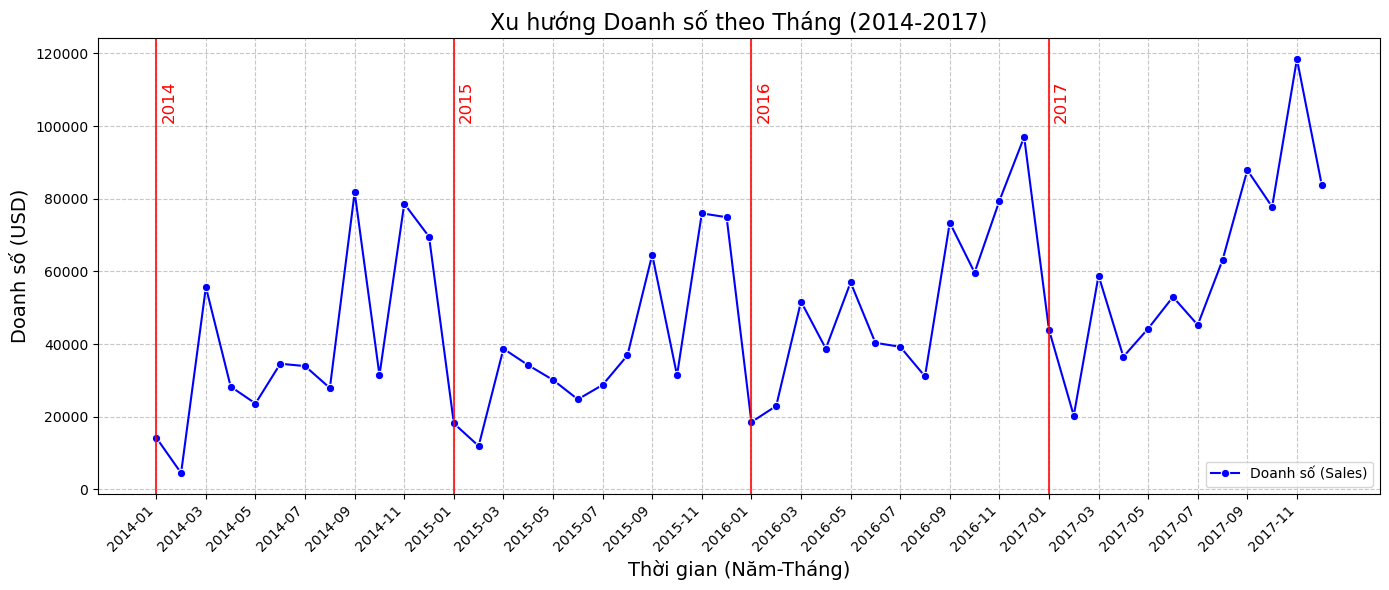

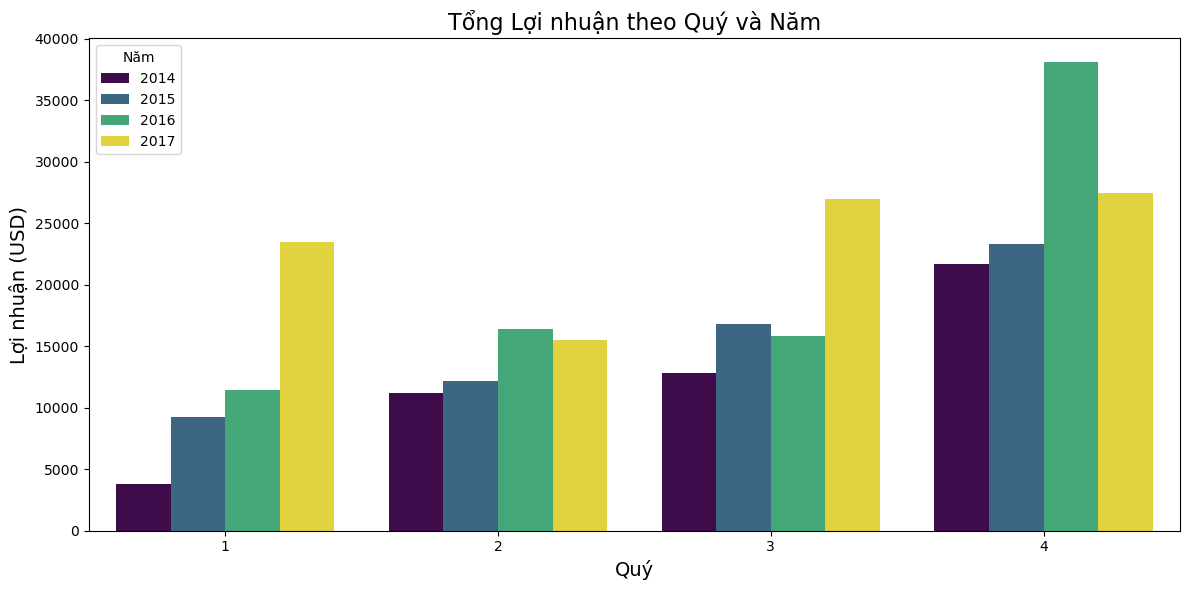

In [23]:
# Biểu đồ 1: Xu hướng Doanh số theo Tháng (Liên tục)
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearMonth', y='Sales', data=monthly_data, marker='o', color='blue', label='Doanh số (Sales)')
plt.title('Xu hướng Doanh số theo Tháng (2014-2017)', fontsize=16)
plt.xlabel('Thời gian (Năm-Tháng)', fontsize=14)
plt.ylabel('Doanh số (USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Lấy danh sách tất cả các giá trị 'YearMonth' duy nhất từ dữ liệu
all_months = monthly_data['YearMonth'].tolist()

# Các mốc phân chia năm (Tháng 1 của các năm tiếp theo)
year_markers = ['2014-01','2015-01', '2016-01', '2017-01'] 

# Lặp qua các mốc và kẻ đường dọc (vertical line)
for year_start in year_markers:
    if year_start in all_months:
        # Lấy vị trí chỉ mục (index) của tháng bắt đầu năm. Vị trí này là nơi đường được vẽ.
        x_position = all_months.index(year_start)
        
        # Kẻ đường dọc tại vị trí đó
        plt.axvline(x=x_position, color='red', linestyle='-', linewidth=1.5, alpha=0.8, label=f'Bắt đầu Năm {year_start[:4]}') # Kẻ đường phân cách
        
        # Thêm chú thích năm bên cạnh đường
        # Ta đặt chú thích hơi lệch sang phải (+ 0.2) để không che đường
        max_sales = monthly_data['Sales'].max()
        plt.text(x=x_position + 0.2, y=max_sales * 0.95, 
                 s=f'{year_start[:4]}', # Hiển thị năm (ví dụ: '2015')
                 color='red', rotation=90, verticalalignment='top', fontsize=12)

# Chỉ hiển thị các mốc 2 tháng một lần để tránh đồ thị quá dày
month_ticks = monthly_data['YearMonth'][::2]
plt.xticks(month_ticks)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Biểu đồ 2: Xu hướng Lợi nhuận theo Năm và Quý
# Tổng hợp theo Năm và Quý
quarterly_data = df.groupby(['Order Year', 'Order Quarter'])[['Sales', 'Profit']].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Order Quarter', y='Profit', hue='Order Year', data=quarterly_data, palette='viridis')
plt.title('Tổng Lợi nhuận theo Quý và Năm', fontsize=16)
plt.xlabel('Quý', fontsize=14)
plt.ylabel('Lợi nhuận (USD)', fontsize=14)
plt.legend(title='Năm', loc='upper left')
plt.tight_layout()
plt.show()

### Nhận xét:
#### 1. Xu hướng Tổng thể theo Năm:
Dữ liệu cho thấy cả Doanh số và Lợi nhuận đều có xu hướng tăng rõ rệt qua từng năm (2014-2017).
- Doanh số: Tăng từ khoảng 484K USD (2014) lên 733K USD (2017).
- Lợi nhuận: Tăng từ khoảng 49K USD (2014) lên 93K USD (2017).
- Điều này cho thấy hoạt động kinh doanh của cửa hàng đang phát triển và mở rộng một cách bền vững.

#### 2. Thời điểm "Đỉnh điểm" và "Thấp điểm":
*Thời điểm "Đỉnh điểm" (Peak Season):*
- Quý 4 (Tháng 10, 11, 12) là quý có Doanh số và Lợi nhuận cao nhất trong tất cả các năm.  
Đặc biệt, Tháng 11 và Tháng 12 luôn là đỉnh điểm, đạt mức Doanh số cao nhất trong năm (Ví dụ: Tháng 11/2017 đạt $118,527). Đây là điều hợp lý do ảnh hưởng của các ngày lễ lớn cuối năm (Thanksgiving, Black Friday, Giáng Sinh).

*Thời điểm "Thấp điểm" (Dull Season):*
- Các tháng đầu năm, đặc biệt là Tháng 1 và Tháng 2, thường là thời điểm có Doanh số và Lợi nhuận thấp nhất. Lý do có thể vì ngay sau kỳ nghỉ lễ cuối năm, khách hàng có xu hướng thắt chặt chi tiêu, và Tháng 1 và Tháng 2 là thời điểm mùa đông lạnh nhất tại Mỹ nên làm giảm lượng khách đến siêu thị.

#### 3. Mẫu hình xu hướng theo mùa:
- Mẫu hình lặp lại: Biểu đồ đường thể hiện một mẫu hình mùa vụ lặp đi lặp lại: Thấp điểm vào đầu năm (Q1), tăng trưởng ổn định (Q2, Q3), và tăng vọt mạnh mẽ vào cuối năm (Q4).
- Sự bất thường: Mặc dù xu hướng tổng thể là tăng, nhưng có những tháng có lợi nhuận âm (thua lỗ) trong chuỗi thời gian, ví dụ như Tháng 7/2014 (cần phân tích sâu hơn tại sao).

## 6. Sản phẩm nào thuộc nhóm "hot items" chỉ bán chạy trong các tháng cụ thể?
*'Hot items': những sản phẩm, mặt hàng bán chạy, có số lượng bán ra nhiều và doanh thu cao.*

### A. Preprocessing

#### 1. Thiết lập Ngưỡng Kép (Sales & Quantity)
- Tính $\text{Q3}$ (Phân vị thứ 75) cho cả Tổng Doanh số ($\text{Product Total Sales}$) và Tổng Số lượng ($\text{Product Total Quantity}$) của mỗi sản phẩm trong toàn bộ 4 năm.

#### 2. Lọc ra  "Hot Items"
- Lọc ra các sản phẩm thỏa mãn đồng thời cả $\text{Sales} \ge \text{Q3}$ và $\text{Quantity} \ge \text{Q3}$. Nhóm sản phẩm này là nền tảng cho việc phân tích tính mùa vụ.

#### 3. Tính Doanh số trung bình hàng tháng trên Tổng Doanh số (Monthly Sales Share):
- Tính tỉ lệ đóng góp doanh số của một tháng cho sản phẩm đó: $Monthly Sales Share = \frac{\text{Sales}_{Product, Month}}{\text{Sales}_{Product, Total}}$
- *Lý do*: Tỷ lệ này giúp xác định tính tập trung của doanh số theo tháng. Sản phẩm có tỷ lệ này cao (ví dụ: > 50% doanh số rơi vào 1-2 tháng) là sản phẩm có tính mùa vụ cao.

In [24]:
# 1. Tính Tổng Sales và Tổng Quantity cho mỗi Sản phẩm trong toàn bộ thời gian
product_total_metrics = df.groupby('Product Name').agg(
    Product_Total_Sales=('Sales', 'sum'),
    Product_Total_Quantity=('Quantity', 'sum')
).reset_index()

# 2. Tính ngưỡng (Q3) cho cả hai chỉ số
sales_threshold_q3 = product_total_metrics['Product_Total_Sales'].quantile(0.75)
quantity_threshold_q3 = product_total_metrics['Product_Total_Quantity'].quantile(0.75)

print(f"Ngưỡng Tổng Doanh số (Q3): {sales_threshold_q3:.2f} USD")
print(f"Ngưỡng Tổng Số lượng (Q3): {quantity_threshold_q3:.2f} đơn vị")

# 3. Lọc ra các sản phẩm "Hot Items" thỏa mãn cả hai tiêu chí Q3
true_hot_items = product_total_metrics[
    (product_total_metrics['Product_Total_Sales'] >= sales_threshold_q3) &
    (product_total_metrics['Product_Total_Quantity'] >= quantity_threshold_q3)
].copy()

# 4. Tính Doanh số/Số lượng hàng tháng cho các True Hot Items
monthly_product_sales_full = df.groupby(['Product Name', 'Order Month'])[['Sales', 'Quantity']].sum().reset_index() 

# 5. Lọc chỉ những True Hot Items và tính Tỷ lệ đóng góp doanh số hàng tháng
monthly_true_hot_items = pd.merge(
    monthly_product_sales_full, 
    true_hot_items[['Product Name', 'Product_Total_Sales', 'Product_Total_Quantity']],
    on='Product Name',
    how='inner'
)

monthly_true_hot_items['Monthly Sales Share'] = (
    monthly_true_hot_items['Sales'] / monthly_true_hot_items['Product_Total_Sales']
)

print("\nĐã lọc được", monthly_true_hot_items['Product Name'].nunique(), "True Hot Items.")

Ngưỡng Tổng Doanh số (Q3): 1205.63 USD
Ngưỡng Tổng Số lượng (Q3): 27.00 đơn vị

Đã lọc được 171 True Hot Items.


### B. Analysis

Áp dụng tiêu chí $\text{Monthly Sales Share} > \text{25%}$ cho nhóm $\text{Hot Items}$ để xác định các sản phẩm có tính mùa vụ cao nhất. Ngưỡng $\text{25%}$ được chọn vì nó cao hơn đáng kể so với tỷ lệ phân bổ đều theo tháng ($\frac{100\%}{12} \approx \text{8.3%}$)

#### 1. Xác định Sản phẩm Mùa vụ:

- Lọc các bản ghi có $\text{Monthly Sales Share} > \text{0.25}$.

#### 2. Trực quan hóa:

- Chọn 4 sản phẩm tiêu biểu nhất để vẽ biểu đồ đường biểu thị Doanh số hàng tháng của riêng chúng.

In [25]:
# Lọc các sản phẩm "True Hot Items" có Tỷ lệ Doanh số Tháng cao (> 25% tổng doanh số)
seasonal_hot_items_combined = monthly_true_hot_items[
    monthly_true_hot_items['Monthly Sales Share'] > 0.25
].sort_values(by=['Product_Total_Sales', 'Monthly Sales Share'], ascending=False)

# Lấy các sản phẩm duy nhất để trực quan hóa
seasonal_hot_items_unique_combined = seasonal_hot_items_combined.drop_duplicates(subset=['Product Name'])

print("Top 5 Sản phẩm Hot Item Mùa vụ (Sales & Quantity cao, tập trung > 25% vào 1 tháng):")
print(seasonal_hot_items_unique_combined[['Product Name', 'Order Month', 'Monthly Sales Share', 'Product_Total_Quantity']].head())

Top 5 Sản phẩm Hot Item Mùa vụ (Sales & Quantity cao, tập trung > 25% vào 1 tháng):
                                         Product Name  Order Month  \
455      HON 5400 Series Task Chairs for Big and Tall            5   
301        GBC DocuBind TL300 Electric Binding System            8   
312  GBC Ibimaster 500 Manual ProClick Binding System           12   
470              Hewlett Packard LaserJet 3310 Copier           10   
289         GBC DocuBind P400 Electric Binding System            1   

     Monthly Sales Share  Product_Total_Quantity  
455             0.288462                      39  
301             0.343891                      37  
312             0.604000                      48  
470             0.286624                      38  
289             0.303030                      27  


### C. Results & Interpretation

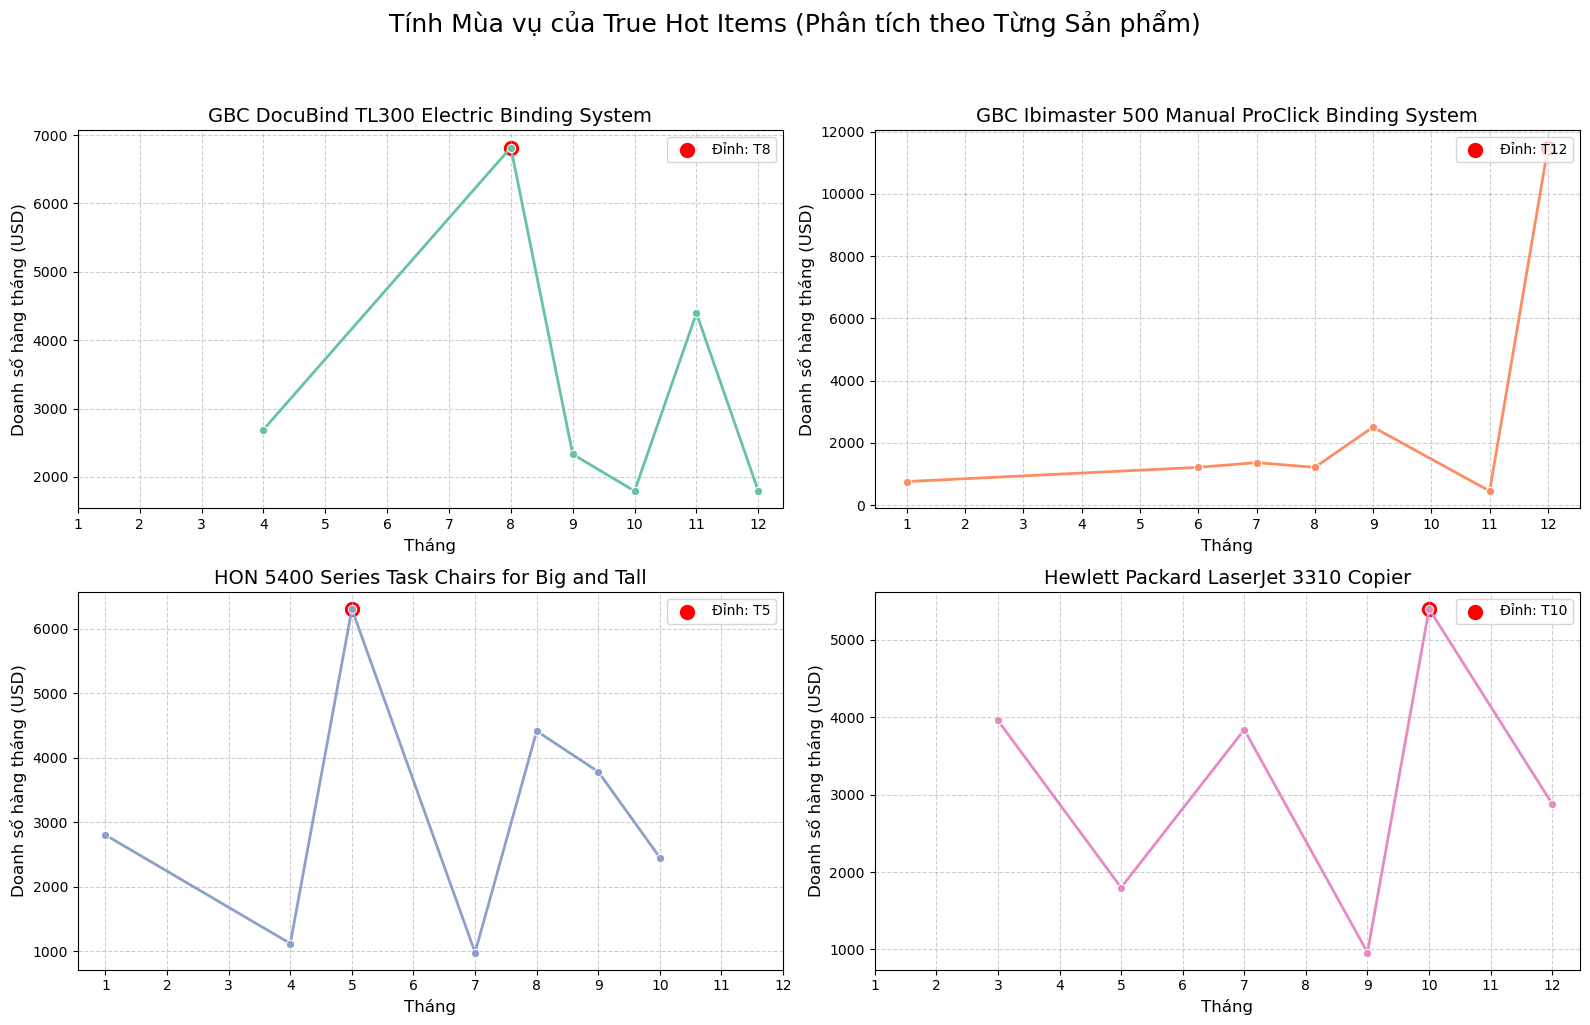

In [26]:
# Chọn Top 4 sản phẩm có tính mùa vụ cao nhất từ nhóm True Hot Items
top_seasonal_products_combined = seasonal_hot_items_unique_combined['Product Name'].head(4).tolist()
viz_data_combined = monthly_true_hot_items[monthly_true_hot_items['Product Name'].isin(top_seasonal_products_combined)]

# 1. Chọn dữ liệu cho 4 sản phẩm chính
top_seasonal_products_combined = viz_data_combined['Product Name'].unique()
n_products = len(top_seasonal_products_combined)

# 2. Thiết lập lưới đồ thị Small Multiples
plt.figure(figsize=(16, 10))
plt.suptitle('Tính Mùa vụ của True Hot Items (Phân tích theo Từng Sản phẩm)', fontsize=18, y=1.02)

for i, product_name in enumerate(top_seasonal_products_combined):
    # Lọc dữ liệu cho từng sản phẩm
    plot_data = viz_data_combined[viz_data_combined['Product Name'] == product_name]
    
    # Tạo subplot
    plt.subplot(2, 2, i + 1) # Tạo lưới 2 hàng, 2 cột
    
    # Vẽ biểu đồ đường
    sns.lineplot(
        x='Order Month', 
        y='Sales', 
        data=plot_data, 
        marker='o', 
        color=sns.color_palette("Set2")[i], # Sử dụng màu khác nhau cho từng subplot
        linewidth=2
    )
    
    # Đánh dấu tháng đỉnh điểm (Max Sales)
    max_sales_month = plot_data.loc[plot_data['Sales'].idxmax()]
    plt.scatter(
        max_sales_month['Order Month'], 
        max_sales_month['Sales'], 
        color='red', 
        s=100, 
        label=f"Đỉnh: T{int(max_sales_month['Order Month'])}"
    )
    
    plt.title(f'{product_name}', fontsize=14)
    plt.xlabel('Tháng', fontsize=12)
    plt.ylabel('Doanh số hàng tháng (USD)', fontsize=12)
    plt.xticks(range(1, 13))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Điều chỉnh layout để không đè lên suptitle
plt.show()

#### 1. Trả lời Câu hỏi:
- Các mặt hàng được coi là "Hot Items" là những sản phẩm có tổng doanh số cao và số lượng bán ra nhiều (trên $\text{Q3}$ toàn bộ) và có hơn $\text{25%}$ doanh số rơi vào một tháng duy nhất. (ví dụ: HON 5400 Series Task Chairs for Big and Tall (ghế văn phòng) vào tháng 5)

#### 2. Giải thích và Ý nghĩa Thực tiễn:
- Các hệ thống đóng sách (Binding Systems) đạt đỉnh vào Tháng 8 (chuẩn bị năm học mới/kế hoạch quý 3) và Tháng 12 (kết thúc năm tài chính, đóng báo cáo niêm yết). 
- Máy copy (Hewlett Copier) cũng có xu hướng chạm đỉnh vào đầu quý 4 trong năm (in tài liệu báo cáo cuối năm).
- Ghế văn phòng cao cấp (HON Chairs) đạt đỉnh vào Tháng 5, có thể liên quan đến các đợt thay đổi nội thất văn phòng định kỳ vào giữa năm.
- **Ý nghĩa:** Điều này có thể phản ánh nhu cầu mua sắm thiết bị văn phòng, nội thất cuối năm cho các công ty hoặc chuẩn bị cho các dự án lớn, hợp đồng mới. Superstore nên tăng cường tồn kho các mặt hàng này vào cuối Quý 3/đầu Quý 4.

#### 3. Nhận xét:
- Các sản phẩm này chủ yếu nằm trong danh mục Office Supplies (Văn phòng phẩm) - nhóm hàng thường có giá trị cao, và việc mua sắm của chúng thường gắn liền với ngân sách và chu kỳ kinh doanh của doanh nghiệp (Phân khúc Corporate/Home Office).
- Đồ thị cho thấy rõ ràng: Doanh số của các sản phẩm này chỉ ở mức trung bình hoặc khá thấp trong nhiều tháng khác và chỉ tăng vọt trong tháng đỉnh điểm, xác nhận tính mùa vụ cao của chúng.

***

# Summary

## Những nhận thức rút ra được sau khi phân tích (Key Findings)

- Thông qua thuật toán **K-Means** (với k=4), tập khách hàng được chia thành các nhóm có hành vi đối lập. Đáng chú ý nhất là nhóm "**VIP**" (Cluster 0) — chi tiêu rất mạnh (khoảng $5,000) nhưng có cũng có Recency khá cao (~3 tháng chưa quay lại).

- Các sản phẩm này đều nằm trong danh mục Office Supplies (Văn phòng phẩm) và Technology (Công nghệ) - nhóm hàng thường có giá trị cao, và việc mua sắm của chúng thường gắn liền với ngân sách và chu kỳ kinh doanh của doanh nghiệp (Phân khúc Corporate/Home Office).

- Đưa ra các chiến lược **Marketing** phù hợp cho từng sản phẩm, tránh trường hợp giảm giá quá sâu không mang lại lợi nhuận và làm lỗ vốn. Khi `Discount` vượt quá một ngưỡng nhất định (thường là > 20%), xác suất rủi ro sẽ tăng.

- Tính mùa vụ đỉnh doanh số rơi vào quý 4, nhưng việc duy trì tồn kho cao cho các mặt hàng này vào Quý 1, 2 sẽ gây lãng phí chi phí lưu kho lớn do nhu cầu "bốc hơi" sau mùa cao điểm.

## Những điểm hạn chế (Limitations)

- Dữ liệu có ít bản ghi chỉ 9994 dòng, chưa đủ để sử dụng các mô hình chuyên sâu đòi hỏi số lượng dữ liệu lớn.

- Dữ liệu chỉ giới hạn trong thị trường United States. Các mô hình dự báo hay hành vi khách hàng tìm được ở đây không thể áp dụng cho thị trường toàn cầu hoặc các quốc gia khác.

- Dữ liệu kết thúc vào năm 2017 (cách đây khá lâu). Hành vi tiêu dùng hiện nay (hậu Covid, bùng nổ E-commerce) có thể đã thay đổi rất khác so với lúc đó.

- Trong phần dự báo lợi nhuận, việc sử dụng **Linear Regression** làm baseline có thể chưa nắm bắt được các mối quan hệ phi tuyến tính phức tạp giữa các biến.

- Chưa kết hợp được các món hàng mà chỉ phân tích đơn lẻ. VD: Bàn thường mua kèm với ghế, Điện thoại đi kèm ốp lưng, tai nghe, ...

## Hướng phát triển trong tương lai (Future Directions)

- **Customer Lifetime Value** (CLV): Thay vì chỉ phân khúc RFM tại một thời điểm, tính toán giá trị vòng đời của khách hàng để biết ai là người mang lại lợi nhuận dài hạn thực sự.

- **Time-Series Forecasting**: Sử dụng các mô hình chuyên sâu hơn như ARIMA hoặc Facebook Prophet để dự báo doanh số bán hàng cho từng Category cụ thể theo tháng/quý, thay vì chỉ phân tích mô tả quá khứ.

## Những suy ngẫm cá nhân (Individual Reflections)

- Thành viên 1 - Cao Tiến Thành:

    - Khó khăn:

        - Khi dự đoán lợi nhuận ban đầu hiệu suất của mô hình khá thấp nhưng sau khi điều chỉnh bằng cách xử lí chuẩn hóa dữ liệu, loại bỏ các giá trị ngoại lai, ... thì hiệu suất mô hình tương đối ổn.

        - Khó khăn lớn gặp phải là việc diễn giải kết quả phân cụm (Clustering Interpretation). Chạy thuật toán ra 4 nhóm thì dễ, nhưng đặt tên và hiểu ý nghĩa kinh doanh ("Nhóm Ngủ đông", "Nhóm VIP") để đề xuất giải pháp thực tế là bước đòi hỏi tư duy logic nhiều nhất.

    - Kiến thức và sự phát triển:

        - Thành thạo hơn thư viện **Pandas** để làm sạch dữ liệu và **Seaborn** để trực quan hóa. Lần đầu tiên làm quen với mô hình học máy không giám sát như **K-means** và **Hierarchical Clustering**.

        - Việc phân tích dữ liệu có thể giúp ích cho lĩnh vực kinh doanh và các lĩnh vực khác rất nhiều chứ không hẳn chỉ mang ý nghĩa hàn lâm.

- Thành viên 2 - Lê Minh Hải:

    - Khó khăn: 
        - Thách thức lớn nhất mà em gặp không phải ở kỹ thuật lập trình mà là việc định hình bài toán. Em nhận thấy việc cảnh báo sớm rủi ro sẽ đem lại nhiều giá trị thực tiễn hơn dự báo doanh thu. Việc chuyển từ bài toán Hồi quy sang bài toán Phân loại đòi hỏi em phải xử lý lại dữ liệu và chọn lựa chọn lại thang đo đánh giá cho phù hợp.
        - Mất cân bằng dữ liệu cũng là một thách thức đối với em, vì số lượng đơn hàng lỗ chỉ chiếm 18% so với tổng dữ liệu. Từ đó em phải thử nhiều phương pháp để tìm ra được điểm cân bằng tối ưu giữa Precision và Recall.
    - Kiến thức và sự phát triển: 
        - Việc hiểu biết về nghiệp vụ (Domain Knowledge) quan trọng ngang với kỹ năng code.
        - Thành thạo quy trình Data Science khép kín: từ làm sạch dữ liệu thô, Feature Engineering đến trực quan hóa kết quả. Và nhận thấy ý nghĩa quan trọng của việc trực quan hóa dữ liệu trong việc phân tích.
        
- Thành viên 3 - Phạm Ngọc Duy:
    - Khó khăn: 
        - Với bản thân em, việc lựa chọn phương pháp trực quan hóa phù hợp cho từng loại dữ liệu cũng là một thách thức. Không phải biểu đồ nào cũng truyền tải thông tin hiệu quả, do đó em phải thử nghiệm nhiều cách biểu diễn khác nhau để tìm ra cách trực quan dễ hiểu và có giá trị phân tích cao nhất.
    - Kiến thức và sự phát triển: 
        - Thông qua đồ án, em hiểu rõ hơn tầm quan trọng của Data Exploration và Data Visualization trong toàn bộ quy trình Data Science. Một biểu đồ tốt có thể giúp phát hiện insight nhanh hơn nhiều so với việc chỉ nhìn vào bảng số liệu.
        - Đồng thời em cũng được cải thiện khả năng đọc và diễn giải kết quả phân tích, không chỉ dừng lại ở việc “kết quả là gì” mà còn suy nghĩ sâu hơn về “tại sao lại như vậy” và “điều này có ý nghĩa gì trong thực tế”.